In [115]:
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.svm import SVR
import matplotlib.pyplot as plt

import tweepy
import nltk
nltk.download('averaged_perceptron_tagger')
from textblob import TextBlob

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

key = 'LwnbPxjRHkxmXAe8z7irHUyjh'
secret = 'z7Yxq5XnvsttSKaYu1B7MsGbtBwDqp0016xlnTMpm5jTgZVzMf'
token = '348375333-qGHNew5Zik0gCR6utON4lB2ergXfq3ZjBYwC3VQk'
token_secret = 'Cbnfpq0KatCzfTk3iATtVUurVaUXiCtfjolBNJvHRcBw5'
np.random.seed(10)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [0]:
auth = tweepy.OAuthHandler(key, secret)
auth.set_access_token(token, token_secret)
api = tweepy.API(auth)
comp_tweets = api.search('Volkswagen')

In [117]:
pos = 0
neg = 0
threshold = 0

for tweet in comp_tweets:
  analysis = TextBlob(tweet.text)
  if analysis.sentiment.polarity >= 0:
    pos += 1
  else:
    neg += 1
    
if pos > neg:
  print('proceed')
  

proceed


In [119]:
data = pd.read_csv('VOW3.DE.csv')

dates = data.Date
dates = pd.Series([int(item.split('-')[2]) for item in dates])
prices = data.Open[2:]

prices.shape

(251,)

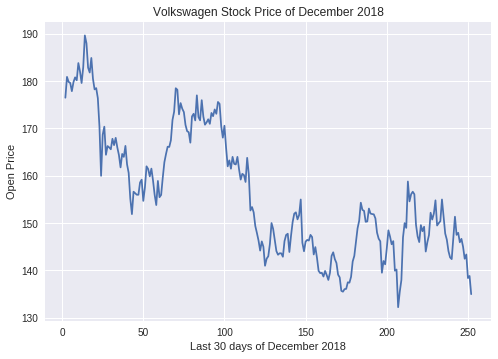

In [120]:
plt.plot(prices)
plt.title('Volkswagen Stock Price of December 2018')
plt.ylabel('Open Price')
plt.xlabel('Last 30 days of December 2018')
plt.show()

In [121]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices.reshape(prices.shape[0], 1))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [122]:
look_back = 3
framed = []
for i in range(len(dates)-look_back+1):
  current = dates[i:i+3].values
  framed.append(current)
  
framed = pd.DataFrame(framed)

framed.shape

(251, 3)

In [141]:
look_back = 30

def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


x, y = create_dataset(scaled_prices, look_back=look_back)
x.shape

(220, 30)

In [142]:
trainX = np.reshape(x, (x.shape[0], x.shape[1], 1))
trainY = y
trainX.shape

(220, 30, 1)

In [0]:
model = Sequential()
model.add(LSTM(20, input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(5, return_sequences=False))
#model.add(Dropout(0.1))
model.add(Dense(1, kernel_initializer='normal', activation='relu'))
model.compile(loss='mse', optimizer='adam')


In [151]:
model.fit(trainX, trainY, epochs=50, batch_size=20, verbose=2, validation_split=0.05)

Train on 209 samples, validate on 11 samples
Epoch 1/50
 - 2s - loss: 0.0157 - val_loss: 0.0117
Epoch 2/50
 - 2s - loss: 0.0159 - val_loss: 0.0042
Epoch 3/50
 - 2s - loss: 0.0163 - val_loss: 0.0051
Epoch 4/50
 - 2s - loss: 0.0162 - val_loss: 0.0084
Epoch 5/50
 - 2s - loss: 0.0141 - val_loss: 0.0047
Epoch 6/50
 - 2s - loss: 0.0132 - val_loss: 0.0069
Epoch 7/50
 - 2s - loss: 0.0128 - val_loss: 0.0057
Epoch 8/50
 - 2s - loss: 0.0124 - val_loss: 0.0054
Epoch 9/50
 - 2s - loss: 0.0125 - val_loss: 0.0059
Epoch 10/50
 - 2s - loss: 0.0125 - val_loss: 0.0055
Epoch 11/50
 - 2s - loss: 0.0127 - val_loss: 0.0067
Epoch 12/50
 - 2s - loss: 0.0123 - val_loss: 0.0049
Epoch 13/50
 - 2s - loss: 0.0120 - val_loss: 0.0047
Epoch 14/50
 - 2s - loss: 0.0116 - val_loss: 0.0057
Epoch 15/50
 - 2s - loss: 0.0104 - val_loss: 0.0043
Epoch 16/50
 - 2s - loss: 0.0105 - val_loss: 0.0062
Epoch 17/50
 - 2s - loss: 0.0104 - val_loss: 0.0037
Epoch 18/50
 - 2s - loss: 0.0104 - val_loss: 0.0063
Epoch 19/50
 - 2s - loss: 0.

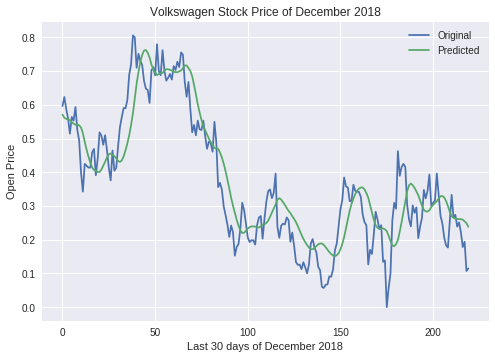

In [162]:
scaled_pred = model.predict(trainX)

pred = scaler.inverse_transform(scaled_pred)

plt.title('Volkswagen Stock Price of December 2018')
plt.ylabel('Open Price')
plt.xlabel('Last 30 days of December 2018')
plt.plot(y, label='Original')
plt.plot(scaled_pred, label='Predicted')
plt.legend()
plt.show()